# Simulação - Servomecanismo

## UNIFEI - Universidade Federal de Itajubá

### Prof. Fernando H. D. Guaracy
### 2º Semestre de 2020 - RTE

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal

from IPython.display import display, clear_output

from scipy.integrate import odeint

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

In [2]:
#Configurações da simulação

ti = 0.001 #Passo de simulação

x0 = 0*math.pi/180 #Posição inicial
sp = 90*math.pi/180 #Setpoint

### Parâmetros do controlador (ganhos e tempo de amostragem)

In [35]:
#Parâmetros do controlador
def sim_setup(Kp,Ki,Kd,Ta):
  return

param=interactive(sim_setup,
         Kp=widgets.FloatSlider(value=2,min=0.0,max=10.0,step=0.01),
         Ki=widgets.FloatSlider(value=0,min=0.0,max=10.0,step=0.01),
         Kd=widgets.FloatSlider(value=0,min=0.0,max=2.0,step=0.01),
         Ta=widgets.FloatSlider(value=0.02,min=0.02,max=0.1,step=0.01));

display(param)

interactive(children=(FloatSlider(value=2.0, description='Kp', max=10.0, step=0.01), FloatSlider(value=0.0, de…

In [36]:
#Modelo do servomecanismo    
def servomecanismo(x, t): 
  global u    

  theta, omega = x
  dxdt = [omega, 185.75*(u+0.1) - 9.80*omega]
      
  return dxdt

In [37]:
#Simulação
def simulacao():
#Parâmetros do controlador
    kp = param.children[0].value
    ki = param.children[1].value
    kd = param.children[2].value

    ta = param.children[3].value

    #Inicialização de variáveis
    global u, vet_t, vet_u, vet_y    
    
    vet_t = []
    vet_u = []
    vet_y = []

    c0 = kp + ta/2*ki + kd/ta 
    c1 = -kp + ta/2*ki - 2*kd/ta    
    c2 = kd/ta
    
    u = 0
    u_1 = 0
    e = 0
    e_1 = 0
    e_2 = 0
    xz = [[x0, 0],[x0, 0]]
    
    tacc = 0
    #Loop de simulação
    for i in range(0,3000,1):
      if ta-tacc <= 0:    
        tacc = 0
        #----Lei de controle------           
        e = (sp - xz[1][0])      
        
        u = u_1 + c0*e + c1*e_1 + c2*e_2
        
        u_1 = u
        e_2 = e_1
        e_1 = e
        #-Fim da lei de controle----

      #----Solução da EDO-------  
      xz = odeint(servomecanismo, xz[1][:], [0,ti])  

      #----Armazenamento de dados----
      vet_t.append(i*ti)
      vet_u.append(u)
      vet_y.append(xz[1][0])
      tacc = tacc+ti;  

    #Gera figuras (estáticas)   
    plt.subplot(2, 1, 1)
    plt.plot(vet_t,np.multiply(np.ones(len(vet_t)),sp*180/math.pi),'k')
    plt.plot(vet_t, np.multiply(vet_y,180/math.pi))
    plt.ylabel('Ângulo [graus]')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(vet_t, vet_u)
    plt.xlabel('Tempo [s]')
    plt.ylabel('Tensão [V]')

    plt.grid(True)        
    return 

In [38]:
%%capture

#Figuras para animação
fig, (ax1, ax2) = plt.subplots(2,1)

line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

ax1.set_ylim(x0*180/math.pi, 2*sp*180/math.pi)
ax1.set_xlim(0, 3)
ax1.grid()
ax1.plot(vet_t,np.multiply(np.ones(len(vet_t)),sp*180/math.pi),'k--')
ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)
ax2.plot([0,math.cos(sp)],[0,math.sin(sp)],'k--')
plt.gca().set_aspect('equal', adjustable='box')

def init_anim():
    line[0].set_data([], [])
    line[1].set_data([], [])
    return line

def animate_func(i):   
    x1 = vet_t[0:i*20]
    y1 = np.multiply(vet_y[0:i*20],180/math.pi)
    x2 = [0,math.cos(vet_y[i*20])]
    y2 = [0,math.sin(vet_y[i*20])]
    line[0].set_data(x1,y1)
    line[1].set_data(x2,y2)
    return line

def animate_fig():
    anim = animation.FuncAnimation(fig, animate_func, init_func=init_anim,
                               frames=150, interval=20, 
                               blit=True, repeat=False)
    display(HTML(anim.to_jshtml()))
    return 

In [39]:
#Definição dos botões para simulação
def button_static_click(b):
    button_anim.disabled = False
    clear_output(wait=True)
    display(button_static)
    simulacao()        
    return

button_static = widgets.Button(
    description='Simular (estático)',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simular',
    icon='gear' # (FontAwesome names without the `fa-` prefix)
)

button_static.on_click(button_static_click)

def button_anim_click(b):
    b.disabled = True
    clear_output(wait=True)
    display(button_anim)
    animate_fig()
    b.disabled = False
    return

button_anim = widgets.Button(
    description='Simular (animação)',
    disabled=True,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='OBS: execute a simulação estática antes',
    icon='gear' # (FontAwesome names without the `fa-` prefix)
)

button_anim.on_click(button_anim_click)

Button(button_style='info', description='Simular (estático)', icon='gear', style=ButtonStyle(), tooltip='Simul…

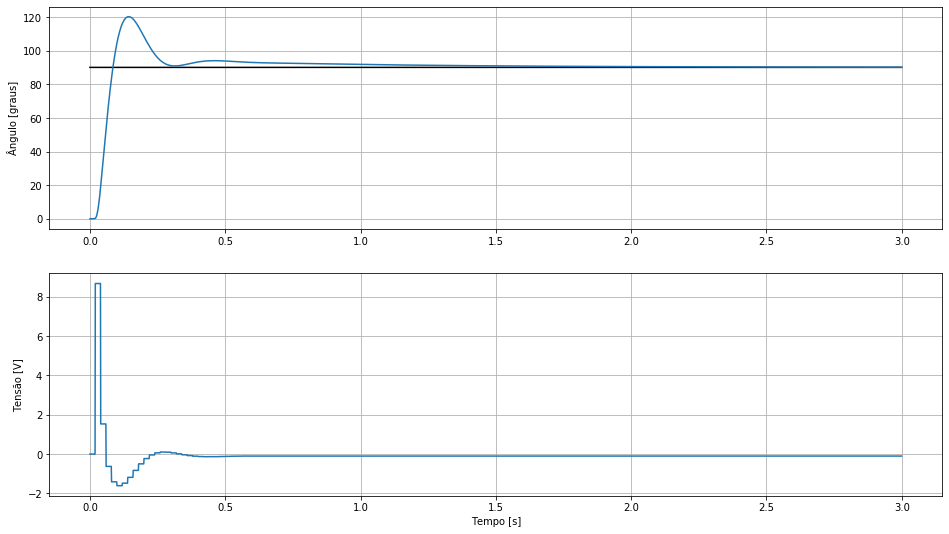

In [40]:
display(button_static)

In [41]:
display(button_anim)

Button(button_style='info', description='Simular (animação)', disabled=True, icon='gear', style=ButtonStyle(),…